# Visualización 3D de Modelo OBJ — Hamburger_01
## Computación Visual — Semana 01: Construyendo un Mundo 3D

Este notebook carga un modelo `.OBJ`, analiza su estructura geométrica y lo visualiza con colores distintos para **vértices**, **aristas** y **caras**. Al final se exporta una animación GIF con la malla rotando.

**Herramientas:** `trimesh`, `vedo`, `numpy`, `matplotlib`, `imageio`

---
> **Colab:** Sube `Hamburger_01.obj` y `Hamburger_01.mtl` al entorno antes de ejecutar las celdas.

## Parte 1 — Instalacion e Importacion de Librerias

Se instalan las dependencias necesarias y se importan los modulos requeridos.

- **trimesh**: carga y analisis de mallas 3D.
- **vedo**: visualizacion interactiva de geometria 3D.
- **numpy**: operaciones numericas sobre arrays de coordenadas.
- **matplotlib**: renderizado 3D estatico y generacion de frames para el GIF.
- **imageio**: exportacion de animaciones GIF.

In [1]:
import subprocess, sys

_packages = ["trimesh", "vedo", "matplotlib", "numpy", "imageio[ffmpeg]", "Pillow"]
subprocess.check_call([sys.executable, "-m", "pip", "install", *_packages, "-q"])

import trimesh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import imageio
import io
import os
import warnings
warnings.filterwarnings("ignore")

print(f"trimesh   : {trimesh.__version__}")
print(f"numpy     : {np.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"imageio   : {imageio.__version__}")

trimesh   : 4.11.2
numpy     : 2.4.2
matplotlib: 3.10.8
imageio   : 2.37.2


---
## Parte 2 — Carga del Modelo 3D (.OBJ) con Trimesh y Vedo

### 2a — Trimesh
`trimesh.load()` lee el `.OBJ` junto con su `.mtl`. Cuando hay múltiples submallas, se unifican con `trimesh.util.concatenate()` para facilitar el análisis estructural posterior.

- Acceso a vértices, aristas y caras como arrays NumPy.
- Propiedades geométricas: volumen, área, bounding box.
- Soporte: `.OBJ`, `.STL`, `.GLTF`, `.PLY`, entre otros.

### 2b — Vedo
`vedo.load()` lee el mismo `.OBJ` respetando el archivo `.mtl` y aplica automáticamente los colores difusos (`Kd`) por submalla y normales suaves por vértice (sombreado Phong).

In [2]:
OBJ_PATH = "Hamburger_01.obj"

try:
    loaded = trimesh.load(OBJ_PATH, force="mesh")

    if isinstance(loaded, trimesh.Scene):
        geometries = list(loaded.geometry.values())
        mesh = trimesh.util.concatenate(geometries)
        print(f"Escena con {len(geometries)} submalla(s) unificadas.")
    else:
        mesh = loaded
        print("Malla unica cargada.")

    print(f"Archivo: {OBJ_PATH}")
    print(f"Tipo   : {type(mesh)}")

except FileNotFoundError:
    print(f"No se encontro el archivo: {OBJ_PATH}")

Malla unica cargada.
Archivo: Hamburger_01.obj
Tipo   : <class 'trimesh.base.Trimesh'>


Malla unica cargada con su material.


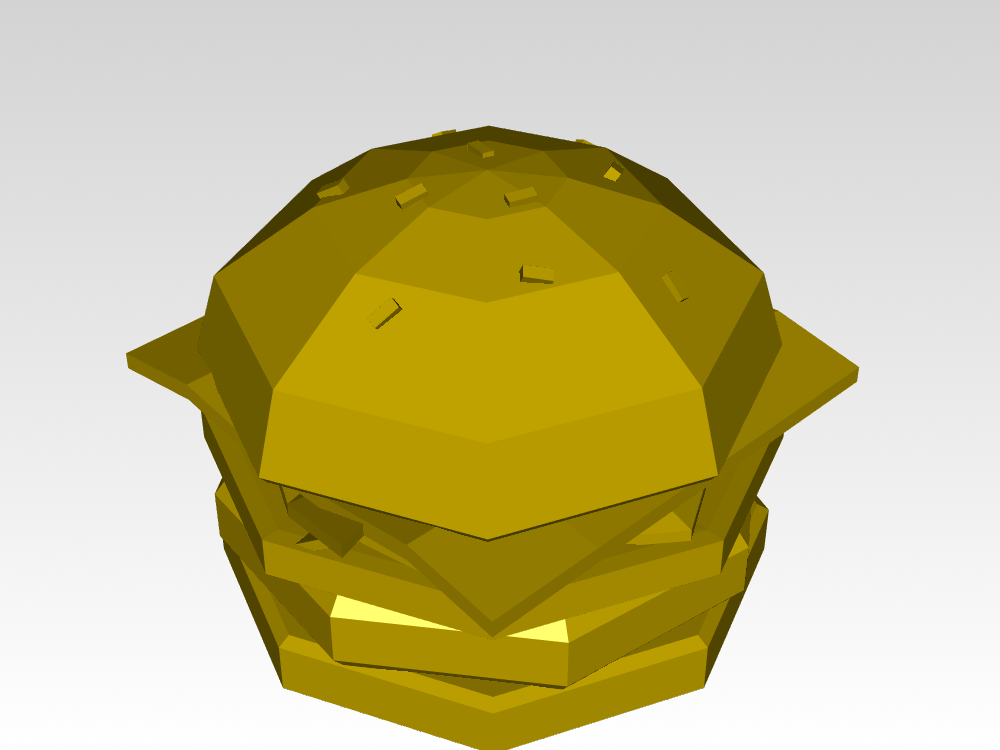


Submallas:
  [1] vertices: 1,768  caras: 470  RGB: (255,236,133)
Guardado como 'hamburger_colores_reales.png'


In [3]:
import vedo
from IPython.display import Image as IPImage, display

obj_scene = vedo.load(OBJ_PATH)

if isinstance(obj_scene, list):
    actors = obj_scene
    print(f"{len(actors)} submalla(s) cargadas con sus materiales.")
else:
    actors = [obj_scene]
    print("Malla unica cargada con su material.")

for actor in actors:
    actor.lighting("glossy")
    actor.compute_normals()

plt_real = vedo.Plotter(offscreen=True, size=(1000, 750), bg="white", bg2="lightgrey")
plt_real.show(*actors, title="Hamburger_01 — Colores y Normales (MTL + Phong)", viewup="y", interactive=False, zoom=1.2)
plt_real.screenshot("hamburger_colores_reales.png")
plt_real.close()

display(IPImage("hamburger_colores_reales.png"))

print("\nSubmallas:")
for i, actor in enumerate(actors):
    c = actor.color()
    r, g, b = int(c[0]*255), int(c[1]*255), int(c[2]*255)
    print(f"  [{i+1}] vertices: {actor.npoints:,}  caras: {actor.ncells:,}  RGB: ({r},{g},{b})")
print("Guardado como 'hamburger_colores_reales.png'")

---
## Parte 3 — Informacion Estructural del Modelo

Todo modelo 3D se define por tres elementos fundamentales:

| Elemento | Descripcion | Propiedad trimesh |
|---|---|---|
| **Vertices** | Puntos en el espacio 3D (x, y, z) | `mesh.vertices` |
| **Aristas** | Segmentos que conectan dos vertices | `mesh.edges_unique` |
| **Caras** | Triangulos formados por 3 vertices | `mesh.faces` |

Adicionalmente se extrae el **bounding box**, el **area de superficie** y el **volumen** si la malla es hermetica (*watertight*).

In [ ]:
n_vertices = mesh.faces.shape[0] * 3
n_edges    = len(mesh.edges_unique)
n_faces    = mesh.faces.shape[0]

bbox   = mesh.bounding_box.extents
bounds = mesh.bounds
area   = mesh.area

print("    INFORMACION ESTRUCTURAL DEL MODELO")
print("=" * 50)
print(f"  Vertices : {n_vertices:>10,}")
print(f"  Aristas  : {n_edges:>10,}")
print(f"  Caras    : {n_faces:>10,}")
print("-" * 50)
print(f"  Bounding Box : {bbox[0]:.4f} x {bbox[1]:.4f} x {bbox[2]:.4f}")
print(f"  Coord. min   : ({bounds[0,0]:.3f}, {bounds[0,1]:.3f}, {bounds[0,2]:.3f})")
print(f"  Coord. max   : ({bounds[1,0]:.3f}, {bounds[1,1]:.3f}, {bounds[1,2]:.3f})")
print(f"  Area total   : {area:.4f} unidades^2")

if mesh.is_watertight:
    print(f"  Volumen      : {mesh.volume:.4f} unidades^3")
    print("  La malla es watertight.")
else:
    print("  La malla NO es watertight.")

print("=" * 50)

euler = mesh.vertices.shape[0] - n_edges + n_faces
print(f"\n  Caracteristica de Euler (V - E + F) = {euler}")

    INFORMACION ESTRUCTURAL DEL MODELO
  Vertices :      2,484
  Aristas  :      2,073
  Caras    :        828
--------------------------------------------------
  Bounding Box : 12.3563 x 10.0299 x 12.7318
  Coord. min   : (-6.186, 0.071, -6.559)
  Coord. max   : (6.170, 10.101, 6.173)
  Area total   : 1527.5153 unidades^2
  La malla NO es watertight.

  Caracteristica de Euler (V - E + F) = 411


---
## Parte 4 — Visualizacion 3D con Matplotlib

Renderizamos la malla usando `matplotlib` con `mpl_toolkits.mplot3d`:

- **Caras** — `Poly3DCollection` con relleno naranja semi-transparente.
- **Aristas** — lineas azules delgadas.
- **Vertices** — puntos rojos dispersos sobre el modelo.

Para modelos densos se aplica submuestreo automatico para mantener la visualizacion fluida.

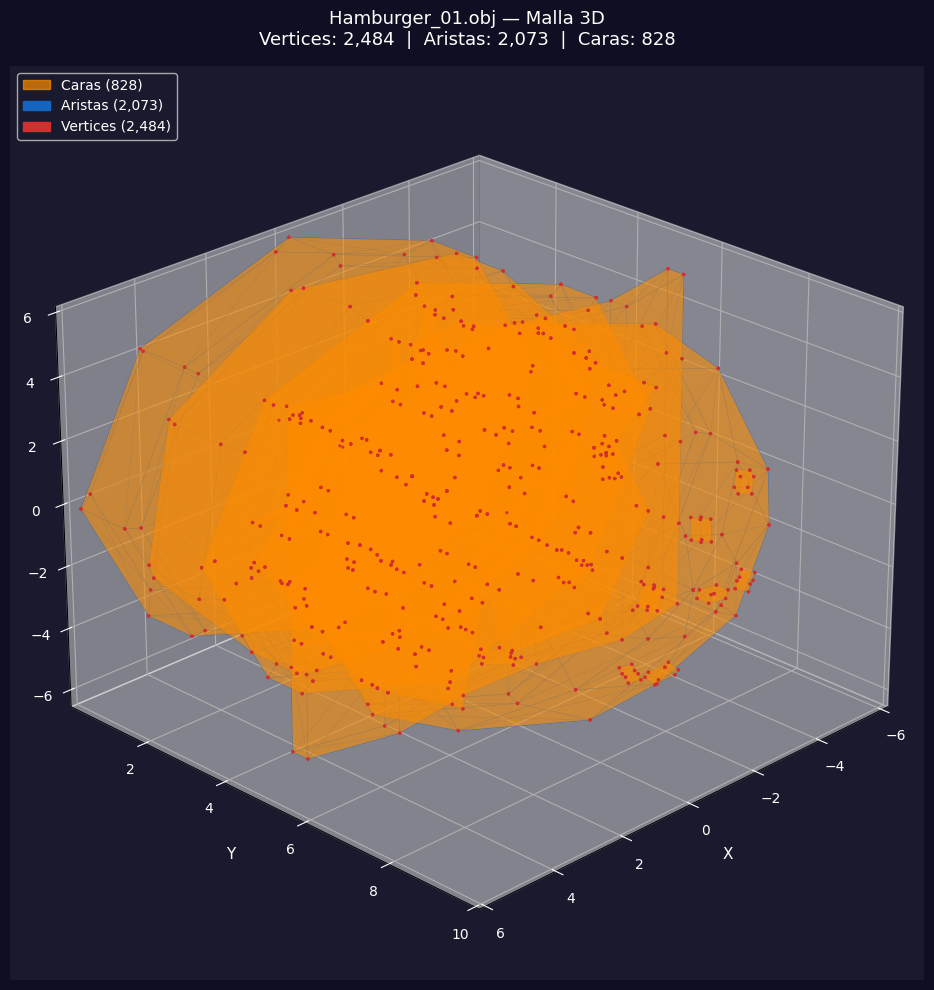

Imagen guardada como 'hamburger_mesh_visualizacion.png'


In [5]:
MAX_FACES    = 4000
MAX_VERTICES = 3000
MAX_EDGES    = 5000

verts = mesh.vertices
faces = mesh.faces
edges = mesh.edges_unique

face_idx = np.random.choice(len(faces), min(MAX_FACES, len(faces)),    replace=False)
vert_idx = np.random.choice(len(verts), min(MAX_VERTICES, len(verts)), replace=False)
edge_idx = np.random.choice(len(edges), min(MAX_EDGES, len(edges)),    replace=False)

faces_draw = faces[face_idx]
verts_draw = verts[vert_idx]
edges_draw = edges[edge_idx]

fig = plt.figure(figsize=(14, 10))
ax  = fig.add_subplot(111, projection="3d")

# Caras
tri_coords = verts[faces_draw]
face_collection = Poly3DCollection(tri_coords, alpha=0.35, facecolor="#FF8C00", edgecolor="none")
ax.add_collection3d(face_collection)

# Aristas
for e in edges_draw:
    p1, p2 = verts[e[0]], verts[e[1]]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="#1565C0", linewidth=0.3, alpha=0.6)

# Vertices
ax.scatter(verts_draw[:, 0], verts_draw[:, 1], verts_draw[:, 2], color="#D32F2F", s=2, alpha=0.8, zorder=5)

ax.set_xlim(bounds[0, 0], bounds[1, 0])
ax.set_ylim(bounds[0, 1], bounds[1, 1])
ax.set_zlim(bounds[0, 2], bounds[1, 2])
ax.set_xlabel("X", fontsize=11, labelpad=8)
ax.set_ylabel("Y", fontsize=11, labelpad=8)
ax.set_zlabel("Z", fontsize=11, labelpad=8)
ax.set_title(
    f"Hamburger_01.obj — Malla 3D\n"
    f"Vertices: {n_vertices:,}  |  Aristas: {n_edges:,}  |  Caras: {n_faces:,}",
    fontsize=13, pad=15
)
ax.view_init(elev=25, azim=45)

ax.set_facecolor("#1a1a2e")
fig.patch.set_facecolor("#0f0f23")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")
ax.title.set_color("white")

legend_handles = [
    mpatches.Patch(color="#FF8C00", alpha=0.7, label=f"Caras ({n_faces:,})"),
    mpatches.Patch(color="#1565C0",             label=f"Aristas ({n_edges:,})"),
    mpatches.Patch(color="#D32F2F",             label=f"Vertices ({n_vertices:,})"),
]
ax.legend(handles=legend_handles, loc="upper left", facecolor="#1a1a2e", labelcolor="white", fontsize=10)

plt.tight_layout()
plt.savefig("hamburger_mesh_visualizacion.png", dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()
print("Imagen guardada como 'hamburger_mesh_visualizacion.png'")

---
## Parte 5 — Visualizacion Interactiva con Vedo

`vedo` permite visualizaciones 3D de alta calidad. Se crean tres objetos separados para diferenciar los componentes:

- `mesh_faces` — relleno naranja de caras.
- `mesh_edges` — wireframe azul (solo aristas).
- `mesh_verts` — puntos rojos en cada vertice.

El renderizado es *offscreen* para compatibilidad con Colab y Jupyter.

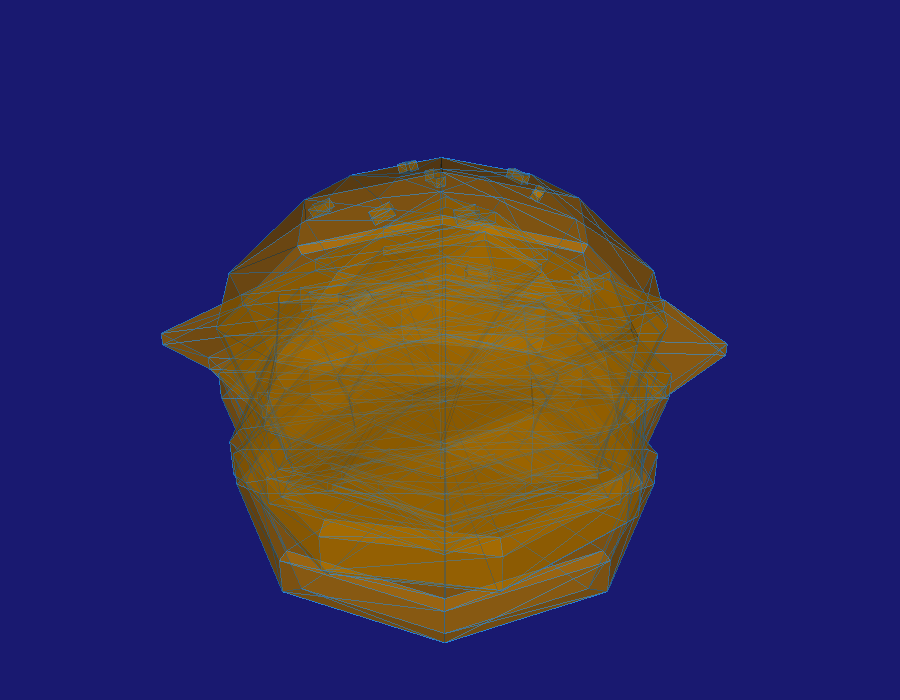

Imagen guardada como 'hamburger_vedo_visualizacion.png'


In [6]:
import vedo
from IPython.display import Image as IPImage, display

vedo.settings.default_backend = "vtk"

vmesh = vedo.Mesh([mesh.vertices, mesh.faces])

# Caras
mesh_faces = vmesh.clone().c("orange").alpha(0.6)
mesh_faces.lighting("plastic")

# Aristas
mesh_edges = vmesh.clone().wireframe(True).c("dodgerblue").lw(0.5).alpha(0.8)

# Vertices (submuestreo)
MAX_VEDO_VERTS = 500
v_sample = mesh.vertices[
    np.random.choice(len(mesh.vertices), min(MAX_VEDO_VERTS, len(mesh.vertices)), replace=False)
]
mesh_verts = vedo.Points(v_sample, r=4).c("tomato")

plt_vedo = vedo.Plotter(offscreen=True, size=(900, 700), bg="midnightblue")
plt_vedo.show(mesh_faces, mesh_edges, mesh_verts,
              title="Hamburger_01 — Vedo: Caras + Aristas + Vertices",
              viewup="y", interactive=False)
plt_vedo.screenshot("hamburger_vedo_visualizacion.png")
plt_vedo.close()

display(IPImage("hamburger_vedo_visualizacion.png"))
print("Imagen guardada como 'hamburger_vedo_visualizacion.png'")

---
## Parte 6 — Animacion Rotacional: Exportar GIF

Se genera una animacion 360° del modelo girando alrededor del eje Y:

1. Se itera el azimut de 0° a 355° en pasos de 6°.
2. En cada paso se renderiza la figura con `ax.view_init(elev, azim)`.
3. Cada frame se guarda en memoria con `io.BytesIO`.
4. Al final `imageio.v3.imwrite()` compila los frames en un GIF con loop infinito.

Generando 60 frames...
  Frame 1/60 — azimut 0°
  Frame 16/60 — azimut 90°
  Frame 31/60 — azimut 180°
  Frame 46/60 — azimut 270°

GIF guardado: 'hamburguer_rotation.gif'  (922.0 KB, 60 frames @ 18 fps)


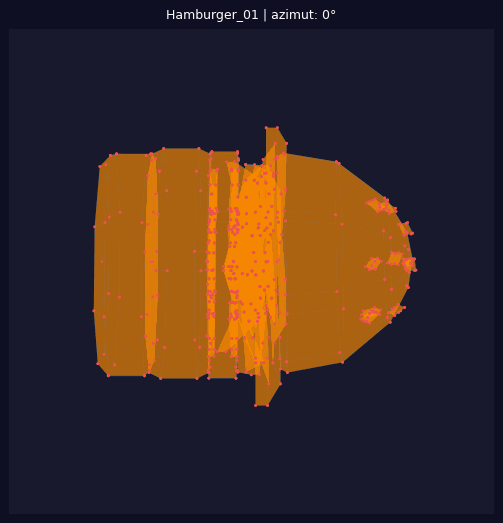

In [7]:
import subprocess, sys

try:
    import imageio.v3 as iio
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imageio[ffmpeg]", "-q"])
    import imageio.v3 as iio

from IPython.display import Image as IPImage, display

GIF_PATH   = "hamburguer_rotation.gif"
ELEV       = 20
FRAME_STEP = 6
FPS        = 18
DPI        = 90
FIG_SIZE   = (9, 7)

total_frames = len(range(0, 360, FRAME_STEP))
print(f"Generando {total_frames} frames...")

MAX_ANIM_FACES = 3000
MAX_ANIM_EDGES = 4000
MAX_ANIM_VERTS = 2000

fidx = np.random.choice(len(faces), min(MAX_ANIM_FACES, len(faces)), replace=False)
eidx = np.random.choice(len(edges), min(MAX_ANIM_EDGES, len(edges)), replace=False)
vidx = np.random.choice(len(verts), min(MAX_ANIM_VERTS, len(verts)), replace=False)

anim_faces = faces[fidx]
anim_edges = edges[eidx]
anim_verts = verts[vidx]
anim_tris  = verts[anim_faces]

frames = []

for azim in range(0, 360, FRAME_STEP):
    fig_anim = plt.figure(figsize=FIG_SIZE, facecolor="#0f0f23")
    ax_anim  = fig_anim.add_subplot(111, projection="3d", facecolor="#1a1a2e")

    col = Poly3DCollection(anim_tris, alpha=0.40, facecolor="#FF8C00", edgecolor="none")
    ax_anim.add_collection3d(col)

    for e in anim_edges:
        p1, p2 = verts[e[0]], verts[e[1]]
        ax_anim.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                     color="#1565C0", linewidth=0.25, alpha=0.5)

    ax_anim.scatter(anim_verts[:, 0], anim_verts[:, 1], anim_verts[:, 2],
                    color="#EF5350", s=1.5, alpha=0.7)

    ax_anim.set_xlim(bounds[0, 0], bounds[1, 0])
    ax_anim.set_ylim(bounds[0, 1], bounds[1, 1])
    ax_anim.set_zlim(bounds[0, 2], bounds[1, 2])
    ax_anim.view_init(elev=ELEV, azim=azim)
    ax_anim.set_axis_off()
    ax_anim.set_title(f"Hamburger_01 | azimut: {azim}°", color="white", fontsize=10, pad=8)

    buf = io.BytesIO()
    fig_anim.savefig(buf, format="png", dpi=DPI, bbox_inches="tight", facecolor=fig_anim.get_facecolor())
    buf.seek(0)
    frames.append(iio.imread(buf))
    buf.close()
    plt.close(fig_anim)

    if (azim // FRAME_STEP) % 15 == 0:
        print(f"  Frame {azim // FRAME_STEP + 1}/{total_frames} — azimut {azim}°")

iio.imwrite(GIF_PATH, frames, extension=".gif", duration=int(1000 / FPS), loop=0)

gif_size_kb = os.path.getsize(GIF_PATH) / 1024
print(f"\nGIF guardado: '{GIF_PATH}'  ({gif_size_kb:.1f} KB, {len(frames)} frames @ {FPS} fps)")

display(IPImage(GIF_PATH))